Medina, Alex - Polarization Phase Curves

In [1]:
#General imports
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import os

#Important imports
import cv2
import vicar

In [2]:
#Essentially the same function as my old code

def image_center(image):
    #Creating a copy of the image to avoid messing with the original

    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    detected_circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=30, maxRadius=500)


    #If a circle is detected this will draw a circle
    if detected_circles is not None:
        detected_circles = np.round(detected_circles[0, :]).astype("int")
        for (x, y, r) in detected_circles:
            #Draw a cirlce of radius 1 around center to show center
            #cv2.circle(image_copy, (x, y), r, (0, 255, 0), 2)
            #Draw a circle of radius r around center to show radius
            #cv2.circle(image_copy, (x, y), 1, (0, 0, 255), 3)
            #Show the image
            #cv2_imshow(image_copy)
            #print({x}, {y})
            return (x, y)
    else:
        print("No circles found")
        return None

#The same as my old code, getting a range of radii and the flux to make a flux vs. radius graph
#To determine the optimal radius
def radii_fluxes_from_image(image, center):
    x, y = center
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    radii = range(1, 1000, 5)
    flux = []

    for r in radii:
        mask = np.zeros_like(gray_image)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)
        #Applying mask to the image
        masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
        flux.append(np.sum(masked))
    return radii, flux

#Visualization of flux and radii for optimal radius
def radii_fluxes_plot(radii, flux):
    plt.plot(radii, flux)
    plt.xlabel("Radius")
    plt.ylabel("Flux")
    plt.title("Flux vs Radius")
    plt.show()

#Finding the optimal radius as before
def optimal_radius_of_image(radii, flux):
    for i in range(1, len(flux)):
        if flux[i] - flux[i-1] < 0.01 * flux[i-1]:
            return radii[i]
    return radii[-1]

For n_pixel, I have to change to number of actual pixels. Unlike I/F, degree of linear polarization is unitless so I can't I can just use the actual number of pixels.

In [3]:
def degree_of_linear(image, center, radius):

    mask = np.zeros_like(image)

    #Fills the circle with 1s and the outside is 0
    #So that when we sum, we multiply the image by the mask, and the 0 multiplication
    #Gets ride of eveything outside of the disk
    #And everything inside the disk is summed but stays the same because multiplied by 1
    cv2.circle(mask, center, radius, 1, thickness=-1)

    total_IF = np.sum(image * mask)
    n_pixel = np.sum(mask)

    return total_IF / n_pixel

In [4]:
#Folder with the calibrated POLARIZED images
polarized_images = r'C:\Users\alexi\Desktop\Research\Cassini_Images\BL2_P\BL2_POL'

#Its the same for the COORDINATE images because I just put them all in the same folder, but have different endings
coordinate_images = r'C:\Users\alexi\Desktop\Research\Cassini_Images\BL2_P\BL2_POL'

#.csv file
metadata_file    = r'C:\Users\alexi\Desktop\Research\Cassini_Images\BL2_P\BL2_POL\pol_data.csv'
#Reading the csv file
parameters_df = pd.read_csv(metadata_file)

So, it turns out this is kinda difficult, but here is the rundown of what I think works: I can group the center and radius (x, y, r) and create a dictionary, in the folder there are three .VIC that correspond to the same image, hence they have the same beginning but different ending, i.e NXXXXXX_pol.vic and NXXXXXXX_I_over_F.vic, so we can match the corrdinates from the I_over_F coordinates to the _pol.vic

In [5]:
#Grouping the circle center and radius for our dictionary
def find_circle_params(image_path):
    vic = vicar.VicarImage(image_path, strict=False)
    image = vic.data_2d
    center = image_center(image)
    radii, fluxes = radii_fluxes_from_image(image, center)
    optimal_radius = optimal_radius_of_image(radii, fluxes)
    return center, optimal_radius

#Creating a dictionary with the opus_id is used as the key since it matches the polarized images
#And the corresponding center coordinates and optimal radius are stored as the value

circle_params = {}
for filename in os.listdir(coordinate_images):
    if filename.endswith('_I_over_F.vic'):
        coordinate_image_path = os.path.join(coordinate_images, filename)
        opus_id = filename.split('_')[0]
        try:
            center, optimal_radius = find_circle_params(coordinate_image_path)
            circle_params[opus_id] = (center, optimal_radius)
            print(f'{filename}: {center}, {optimal_radius}')
        except Exception as e:
            print(f"{filename}: {e}")

N1486913_I_over_F.vic: (np.int64(251), np.int64(272)), 186
N1499415_I_over_F.vic: (np.int64(259), np.int64(256)), 266
N1515805_I_over_F.vic: (np.int64(256), np.int64(262)), 206
No circles found
N1521213_I_over_F.vic: cannot unpack non-iterable NoneType object
N1525327_I_over_F.vic: (np.int64(527), np.int64(520)), 511
N1526619_I_over_F.vic: (np.int64(239), np.int64(266)), 271
N1530756_I_over_F.vic: (np.int64(532), np.int64(519)), 541
N1534852_I_over_F.vic: (np.int64(489), np.int64(515)), 541
N1536146_I_over_F.vic: (np.int64(503), np.int64(514)), 536
N1547135_I_over_F.vic: (np.int64(524), np.int64(518)), 541
N1549546_I_over_F.vic: (np.int64(512), np.int64(501)), 536
N1551056_I_over_F.vic: (np.int64(245), np.int64(247)), 261
N1553821_I_over_F.vic: (np.int64(256), np.int64(267)), 266
N1555150_I_over_F.vic: (np.int64(267), np.int64(273)), 246
N1557905_I_over_F.vic: (np.int64(242), np.int64(284)), 231
N1559282_I_over_F.vic: (np.int64(247), np.int64(283)), 201
N1562037_I_over_F.vic: (np.int64

In [7]:
#List lists for results
degree_of_lp = []
phase_angles = []

#Because the .IMG calibrated images don't match 1:1 with the metadata, we have to do some fun things
#Same loop as before but additional if for center coords and radius
for filename in os.listdir(polarized_images):
    if filename.endswith('_Pol.vic'):
    #if filename.endswith('_Theta.vic'):
    #if filename.endswith('_Q.vic'):
        polarized_image_path = os.path.join(polarized_images, filename)
        vic = vicar.VicarImage(polarized_image_path, strict=False)
        image = vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, optimal_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Assocating the meta data with the image, pixel_scale and phase_angle
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]

                dlop = degree_of_linear(image, center, optimal_radius)

                #dlop_abs = np.abs(dlop)

                #Creating array to plot
                phase_angles.append(phase_angle)
                degree_of_lp.append(dlop)

                #For manual inspection
                print(f'{filename}: {dlop}')

N1486913_Pol.vic: 0.07169073075056076
N1499415_Pol.vic: 0.36898505687713623
N1515805_Pol.vic: 0.18476657569408417
N1525327_Pol.vic: 0.23695318400859833
N1526619_Pol.vic: 0.5799213647842407
N1530756_Pol.vic: 0.4260235130786896
N1534852_Pol.vic: 0.41073814034461975
N1536146_Pol.vic: 0.3678963780403137
N1547135_Pol.vic: 0.4825606942176819
N1549546_Pol.vic: 0.5208328366279602
N1551056_Pol.vic: 0.42319127917289734
N1553821_Pol.vic: 0.25240957736968994
N1555150_Pol.vic: 0.18092063069343567
N1557905_Pol.vic: 0.07992187887430191
N1559282_Pol.vic: 0.05379948765039444
N1562037_Pol.vic: 0.04596962779760361
N1577094_Pol.vic: 0.20727895200252533
N1579533_Pol.vic: 0.3632326126098633
N1582634_Pol.vic: 0.3705280125141144
N1585390_Pol.vic: 0.4538154602050781
N1605442_Pol.vic: 0.20651017129421234
N1617163_Pol.vic: 0.5818929672241211
N1617165_Pol.vic: 0.5744184851646423


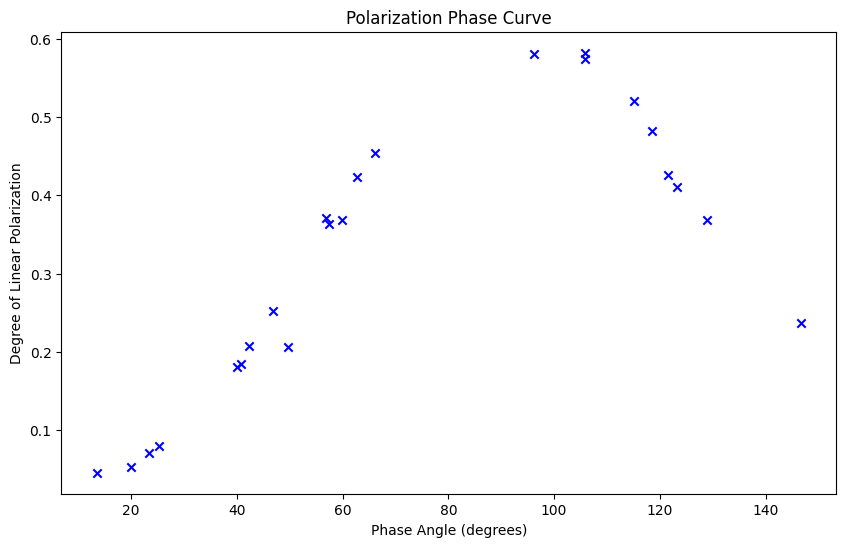

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, degree_of_lp, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Degree of Linear Polarization')
plt.title('Polarization Phase Curve')
plt.show()

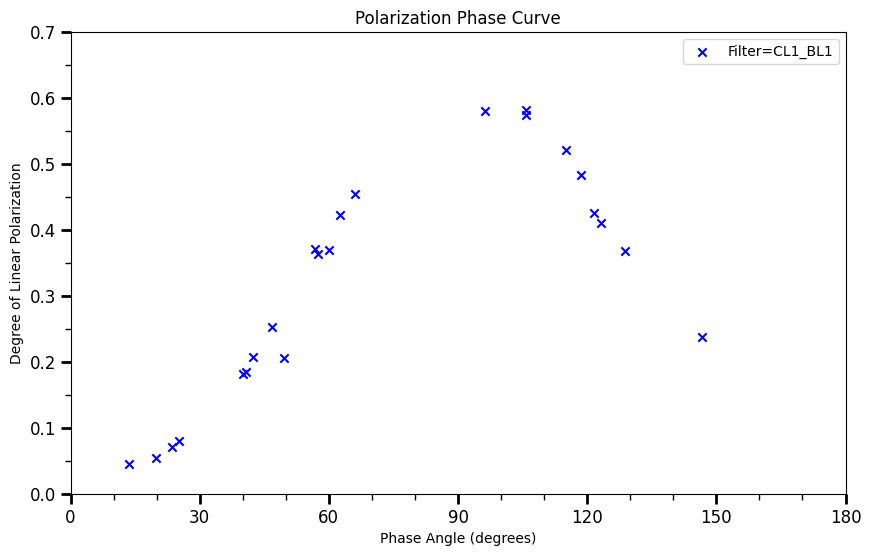

In [12]:
#Fancy plot for consistency across all plots but also visually will look better

filtername = 'CL1_BL1'

#Same size and parameters as before
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, degree_of_lp, color='b', marker='x', label=f'Filter={filtername}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Degree of Linear Polarization')
plt.title('Polarization Phase Curve')

#Selecting x-ticks, for them at every 10 but also every 30 will be more pronounces
ax = plt.gca()
ax.set_xticks(range(0, 181, 30))
ax.set_xticks(range(0, 181, 10), minor=True)

ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=12)
ax.tick_params(axis='x', which='minor', length=4, width=1, labelsize=10)

#Same for the y-axis
#While the x-axis is phase so remains consistent, I use above section of code to determine split on for y-axis
ay = plt.gca()
ay.set_yticks([i * 0.1 for i in range(8)], minor=False)
ay.set_yticks([i * 0.05 for i in range(70)], minor=True) 
plt.ylim(0, 0.70)

ay.tick_params(axis='y', which='major', length=7, width=2, labelsize=12)
ay.tick_params(axis='y', which='minor', length=4, width=1, labelsize=10)

plt.legend()
plt.show()